## Implementation of Gaussian Kernel Regression

Includes bootstrapped prediction intervals, along with utilizing gradient descent to optimize hyperparameter choices.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.losses import MSE

In [2]:
def generate_data_point(x):
    """ generates data
    """
    y = np.sin(x/10.0)+(x/50.0)**2
    y += np.random.normal(0.0,0.15,size=y.shape)
    return y

In [3]:
x = np.arange(0,100,0.01)
y = generate_data_point(x)

In [4]:
indices = np.random.choice(range(0,len(x)),size=300,replace=False)
train_indices = sorted(indices[:100]) # sorted data makes plotting easier
val_indices = sorted(indices[100:200])
test_indices = sorted(indices[200:])

train_x,train_y = x[train_indices],y[train_indices]
val_x,val_y = x[val_indices],y[val_indices]
test_x,test_y = x[test_indices],y[test_indices]

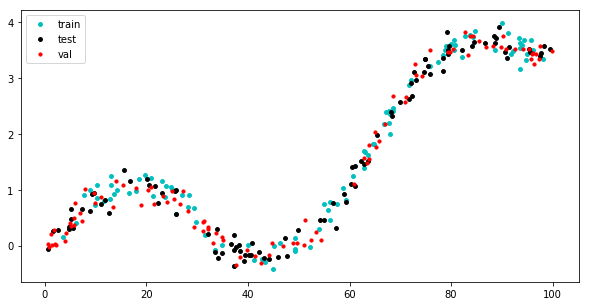

In [5]:
plt.figure(figsize=(10,5))
plt.scatter(train_x,train_y,s=15,c="c",label='train')
plt.scatter(test_x,test_y,s=15,c="k",label='test')
plt.scatter(val_x,val_y,s=10,c="r",label='val')
plt.legend()
plt.show()

In [6]:
def get_kernel_output(test_x,train_x,train_y,h):
    """ generates kernel regression predictions
    """
    test_set_predictions = []
    for x in test_x:
        kernel_out = np.exp(-((train_x-x)**2/h)) # gaussian kernel
        kernel_weights = kernel_out/np.sum(kernel_out)
        pred_y = np.sum(kernel_weights*train_y)
        test_set_predictions.append(pred_y)
        
    return np.array(test_set_predictions)

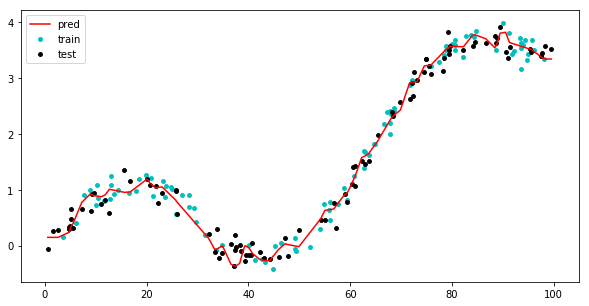

0.036245


In [7]:
# using h=1
preds = get_kernel_output(test_x,train_x,train_y,h=1)
plt.figure(figsize=(10,5))
plt.scatter(train_x,train_y,s=15,c="c",label='train')
plt.scatter(test_x,test_y,c='k',s=15,label='test')
plt.plot(test_x,preds,c='r',label='pred')
plt.legend()
plt.show()
print(round(mean_squared_error(test_y,preds),6))

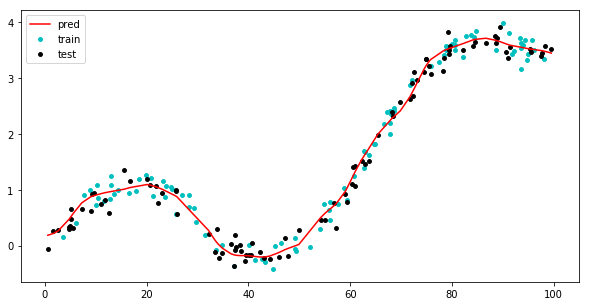

0.027339


In [8]:
# smoother output as h is larger, using h=10
preds = get_kernel_output(test_x,train_x,train_y,h=10)
plt.figure(figsize=(10,5))
plt.scatter(train_x,train_y,s=15,c="c",label='train')
plt.scatter(test_x,test_y,c='k',s=15,label='test')
plt.plot(test_x,preds,c='r',label='pred')
plt.legend()
plt.show()
print(round(mean_squared_error(test_y,preds),6))

### Using gradient methods to find optimal h parameter

This method utilizes the validation set.

In [9]:
epochs = 100
optimizer = Adam(lr=5.0)
h = tf.Variable(np.array([[5.0]])) # initial value

for epoch_i in range(1,epochs+1):
    all_preds = []
    with tf.GradientTape() as tape:
        tape.watch(h)
        for x_ in val_x:
            kernel_out = tf.math.exp(-((train_x-x_)**2/h))
            kernel_weights = kernel_out/tf.math.reduce_sum(kernel_out)
            pred_y = tf.math.reduce_sum(kernel_weights*train_y)
            all_preds.append(pred_y)
        loss = MSE(val_y,all_preds)

        gradients = tape.gradient(loss,h)
        optimizer.apply_gradients(zip([gradients],[h]))
        
    if epoch_i%10==0:
        print("epoch {}; loss:{}".format(epoch_i,round(float(loss),6)))

epoch 10; loss:0.02503
epoch 20; loss:0.024874
epoch 30; loss:0.024899
epoch 40; loss:0.02489
epoch 50; loss:0.024875
epoch 60; loss:0.024876
epoch 70; loss:0.024875
epoch 80; loss:0.024874
epoch 90; loss:0.024874
epoch 100; loss:0.024874


In [10]:
print(h)

<tf.Variable 'Variable:0' shape=(1, 1) dtype=float64, numpy=array([[5.63551111]])>


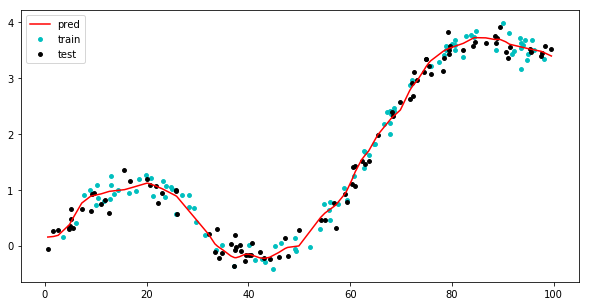

0.026874


In [11]:
# using the learned parameter h
preds = get_kernel_output(test_x,train_x,train_y,h=float(h))
plt.figure(figsize=(10,5))
plt.scatter(train_x,train_y,s=15,c="c",label='train')
plt.scatter(test_x,test_y,c='k',s=15,label='test')
plt.plot(test_x,preds,c='r',label='pred')
plt.legend()
plt.show()
print(round(mean_squared_error(test_y,preds),6))

In [12]:
# comparing the validation errors around the optimal h
preds = get_kernel_output(val_x,train_x,train_y,h=float(h))
print(round(mean_squared_error(val_y,preds),6))
print("--------")

preds = get_kernel_output(val_x,train_x,train_y,h=float(h)-0.5)
print(round(mean_squared_error(val_y,preds),6))
preds = get_kernel_output(val_x,train_x,train_y,h=float(h)-5.0)
print(round(mean_squared_error(val_y,preds),6))

preds = get_kernel_output(val_x,train_x,train_y,h=float(h)+0.5)
print(round(mean_squared_error(val_y,preds),6))
preds = get_kernel_output(val_x,train_x,train_y,h=float(h)+5.0)
print(round(mean_squared_error(val_y,preds),6))

0.024874
--------
0.024909
0.033435
0.024909
0.027055


### Bootstrapped prediction intervals

In [14]:
# generating predictions for each of the bootstrapped samples
input_x = x
input_y = y
all_pred_y = []

for _ in range(1000): # 1000 bootstrapped samples
    pred_y = []
    bootstrap_train_indices = np.random.choice(train_indices,size=80,replace=False)
    bootstrap_train_x = x[bootstrap_train_indices]
    bootstrap_train_y = y[bootstrap_train_indices]
    bootstrap_preds = get_kernel_output(input_x,bootstrap_train_x,bootstrap_train_y,float(h))
    all_pred_y.append(bootstrap_preds)

In [15]:
# generating mean predictions and prediction intervals
bootstrap_pred_y = np.vstack(all_pred_y)
bootstrap_means = np.mean(bootstrap_pred_y,axis=0)
bootstrap_stdev = np.std(bootstrap_pred_y,axis=0)
bootstrap_upper_conf = bootstrap_means + 2*bootstrap_stdev
bootstrap_lower_conf = bootstrap_means - 2*bootstrap_stdev

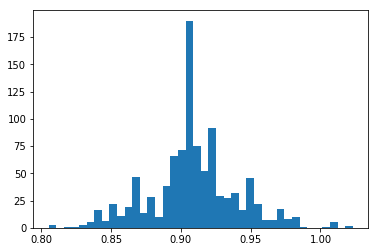

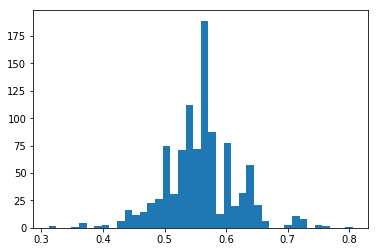

In [19]:
plt.hist(bootstrap_pred_y[:,1000],bins=40)
plt.show()

plt.hist(bootstrap_pred_y[:,3000],bins=40)
plt.show()

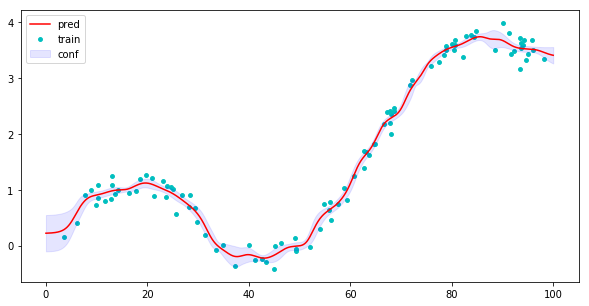

In [20]:
# plotting the prediction interval for all datapoints
fig,ax = plt.subplots()
fig.set_size_inches(10,5)
ax.scatter(train_x,train_y,s=15,c="c",label='train')
ax.plot(input_x,bootstrap_means,c='r',label='pred')
ax.fill_between(input_x,bootstrap_lower_conf,bootstrap_upper_conf,color='b',alpha=0.1,label='conf')
ax.legend()
plt.show()